# CNN

ILSVRC에서 우승을 했던 CNN 구조들은 AlexNet, VGG, GoogLeNet, ResNet이 있다.

초창기에 나온 것은 AlexNet이다. 

Files already downloaded and verified
Files already downloaded and verified
[1,   200] loss: 2.317
[1,   400] loss: 2.311
[1,   600] loss: 2.308
[1,   800] loss: 2.307
[1,  1000] loss: 2.307
[1,  1200] loss: 2.304
[1,  1400] loss: 2.304
[2,   200] loss: 2.303
[2,   400] loss: 2.303
[2,   600] loss: 2.303
[2,   800] loss: 2.303
[2,  1000] loss: 2.303
[2,  1200] loss: 2.302
[2,  1400] loss: 2.302
[3,   200] loss: 2.302
[3,   400] loss: 2.302
[3,   600] loss: 2.302
[3,   800] loss: 2.302
[3,  1000] loss: 2.301
[3,  1200] loss: 2.302
[3,  1400] loss: 2.301
[4,   200] loss: 2.301
[4,   400] loss: 2.300
[4,   600] loss: 2.301
[4,   800] loss: 2.300
[4,  1000] loss: 2.300
[4,  1200] loss: 2.299
[4,  1400] loss: 2.298
[5,   200] loss: 2.297
[5,   400] loss: 2.295
[5,   600] loss: 2.291
[5,   800] loss: 2.289
[5,  1000] loss: 2.283
[5,  1200] loss: 2.278
[5,  1400] loss: 2.265
[] F:  torch.Size([16, 10, 3, 3])
[] npimg shape:  (3, 138, 274)
[] shape:  (138, 274, 3)
[] npimg shape:  (3, 138, 274

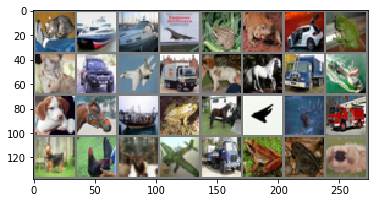

In [97]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True

class DbgLayer(nn.Module):
    def __init__(self):
        super(DbgLayer, self).__init__()
    
    def DbgPrint(self, result):
        print(result.size())

        
class AlexNet(nn.Module):
    def __init__(self, class_num):
        super(AlexNet, self).__init__()
        self.feature_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (11, 11), stride = 4, padding = 2),
            nn.ReLU(inplace = True),
#             DbgLayer(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=2),
            nn.Conv2d(256, 10, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier_network = nn.Sequential(
            nn.Dropout(),
#             nn.Linear(256, class_num)
            nn.Linear(10, class_num)
        )
        
#         self.classifier_network = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 3 * 3, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, class_num)
#         )

        
    def forward(self, x):
        avg = nn.AvgPool2d(3)
        
        f1 = self.feature_network(x)
#         print('[] f1 shape: ', f1.size())
        f2 = avg(f1)
#         f3 = f2.view(-1, 256 * 1 * 1)
        f3 = f2.view(-1, 10 * 1 * 1)
        result = self.classifier_network(f3)
        
        return result, f1
            
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print('[] npimg shape: ', npimg.shape)
    t = np.transpose(npimg, (1, 2, 0))
    print('[] shape: ', t.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print('[] npimg shape: ', npimg.shape)
    
    
def main():
    AN = AlexNet(10)
    param = list(AN.parameters())

#     for p in param:
#         print("[] Type: {},  size: {}".format(type(p), p.size()))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle=True, num_workers=2)


    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(AN.parameters(), lr=0.001, momentum=0.9)
    
    AN.to(device)

    # training
    for epoch in range(5):
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, F = AN.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
                
    print('[] F: ' ,F.size())
    
    # test
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print test images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))


    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, F = AN.forward(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
    print('[] Save network')
    torch.save(AN, 'Alexnet.pt')
          
    
if __name__ == '__main__':
    main()
        

In [96]:
AN2 = torch.load('Alexnet.pt')

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
        for data in testloader:
            images, labels = data
            print(images[0].size())
            images, labels = images.to(device), labels.to(device)
            outputs, F = AN2.forward(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    
print(F.size())

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([

In [124]:
param = list(AN2.parameters())

W = param[10].cpu().data.numpy()
print('[] Weight size: ', W.shape)

# convres = F.cpu().data.numpy()
print('[] ConvResult size: ', F.shape)

conv = F.reshape(10, 9)



[] Weight size:  (10, 10)
[] ConvResult size:  (16, 10, 3, 3)


ValueError: cannot reshape array of size 1440 into shape (10,9)